In [13]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")


import torch
from supplementary import GPTModel
import tiktoken
from supplementary import generate_text_simple


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference





def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

matplotlib version: 3.9.2
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.4.1


In [14]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [15]:
torch.cuda.empty_cache()

In [16]:
with open("homecoming.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 24664
Tokens: 6435


In [18]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [19]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [20]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 5632
Validation tokens: 512
All tokens: 6144


In [21]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.966982581398703
Validation loss: 10.99567985534668


In [22]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.434, Val loss 9.582
Ep 1 (Step 000005): Train loss 7.668, Val loss 7.794
Ep 1 (Step 000010): Train loss 6.336, Val loss 6.616
Every effort moves you the the the the the the the the the the the the the the. ’t the the. ’t. ’t,’t. ’t,’t, the. ’
Ep 2 (Step 000015): Train loss 5.353, Val loss 6.270
Ep 2 (Step 000020): Train loss 5.353, Val loss 6.208
Every effort moves you, and the the the. I” I, and the. “I” I, and the, and the to the a�s, and the, and the, and the�, and the, and, and
Ep 3 (Step 000025): Train loss 4.675, Val loss 6.074
Ep 3 (Step 000030): Train loss 4.098, Val loss 6.164
Every effort moves you’t me, and the’t me to the my core, and the me, and the to her, and the me.’t, and the, and the ground.’t, and I’ts
Ep 4 (Step 000035): Train loss 3.860, Val loss 6.157
Ep 4 (Step 000040): Train loss 3.485, Val loss 6.060
Every effort moves you the and I had been the my fingers,’d had been aether the to her eyes and to be,’s Gambit. ’s Gambit,’s Gamb

In [30]:
torch.save(model.state_dict(), "tbate_model.pth")

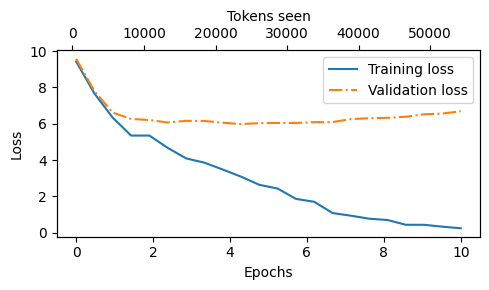

In [31]:
from supplementary import plot_losses

num_epochs=10
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [42]:
start_context = "grey"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [43]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 grey�You’re lying,’t
